In [1]:
import pandas as pd
import supporter
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import joblib
import random
import seaborn as sns
random.seed(7)

#Porcentaje de los datos de entrenamiento
train_size=0.8
#Porcentaje de los datos de Test
test_size=0.2

#Parrilla de hiper-parámetros para GridSearchCV
parameter_space = {
    'epochs': [10,20,50],
    'batch_size' : [10,50,100],
    '_units': [25, 50 ,100]
}

"""optimizer = ['SGD', 'Adam']
init_mode = ['glorot_uniform', 'normal', 'uniform']
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [50, 100, 500]
_units: [25, 50 ,100, 200]"""

#Validación cruzada para series temporales
cv = TimeSeriesSplit(n_splits = 10)

In [2]:
def create_LSTM_model(_optimizer='adam', _init_mode='uniform', _units=50):
    model = Sequential()
    model.add(LSTM(_units, input_shape=(n_predictors, n_features)))
    model.add(Dense(1))
    model.compile(optimizer=_optimizer, loss='mse')
    return model

#Encapsulamos el modelo keras para que sea compatatible con las funciones SkLearn
model_LSTM = KerasRegressor(build_fn=create_LSTM_model, verbose=0)

# 7 días sin información diaria

In [3]:
df_7d_no_info = pd.read_csv(r'./consumo_diario_03_7d_no_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [4]:
X_train_7d_no_info, X_test_7d_no_info, y_train_7d_no_info, y_test_7d_no_info = supporter.split_train_test_deep(df_7d_no_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_7d_no_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_LSTM, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_7d_no_info, y_train_7d_no_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'LSTM_7d_no_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_7d_no_info_RMSE, _7d_no_info_MAE, _7d_no_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                             X_train_7d_no_info,
                                                                                             y_train_7d_no_info, cv,
                                                                                             '7 días sin información diaria')
joblib.dump(_7d_no_info_RMSE, 'LSTM_7d_no_info_normalizado_RMSE_training.pkl')
joblib.dump(_7d_no_info_MAE, 'LSTM_7d_no_info_normalizado_MAE_training.pkl')
joblib.dump(_7d_no_info_MAPE, 'LSTM_7d_no_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('LSTM_7d_no_info_normalizado_best_model.h5')

In [5]:
best_conf = joblib.load('LSTM_7d_no_info_normalizado_best_conf.pkl')
best_conf

{'_units': 50, 'batch_size': 10, 'epochs': 50}

In [6]:
_7d_no_info_RMSE = joblib.load('LSTM_7d_no_info_normalizado_RMSE_training.pkl')
_7d_no_info_MAE = joblib.load('LSTM_7d_no_info_normalizado_MAE_training.pkl')
_7d_no_info_MAPE = joblib.load('LSTM_7d_no_info_normalizado_MAPE_training.pkl')

In [7]:
predictor_7d_no_info = load_model('LSTM_7d_no_info_normalizado_best_model.h5')

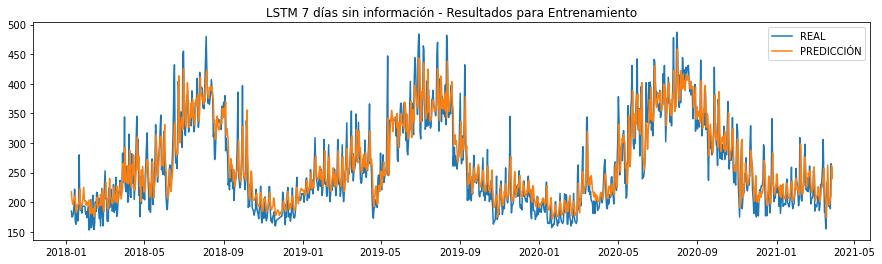

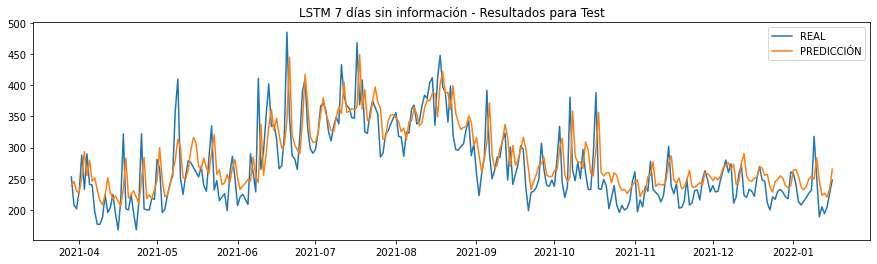

In [8]:
supporter.grafica_resultado(predictor_7d_no_info,"LSTM 7 días sin información", df_7d_no_info,
                            train_size,test_size,show_scaled=False)

In [9]:
supporter.regression_results(y_test_7d_no_info, predictor_7d_no_info.predict(X_test_7d_no_info))

r2:  0.62
MAE:  0.08
MSE:  0.01
RMSE:  0.11
MAPE (%):  23.07


# 7 días con información diaria

In [10]:
df_7d_info = pd.read_csv(r'./consumo_diario_03_7d_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [11]:
X_train_7d_info, X_test_7d_info, y_train_7d_info, y_test_7d_info = supporter.split_train_test_deep(df_7d_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_7d_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_LSTM, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_7d_info, y_train_7d_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'LSTM_7d_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_7d_info_RMSE, _7d_info_MAE, _7d_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                    X_train_7d_info,
                                                                                    y_train_7d_info, cv,
                                                                                    7 días con información diaria')
joblib.dump(_7d_info_RMSE, 'LSTM_7d_info_normalizado_RMSE_training.pkl')
joblib.dump(_7d_info_MAE, 'LSTM_7d_info_normalizado_MAE_training.pkl')
joblib.dump(_7d_info_MAPE, 'LSTM_7d_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('LSTM_7d_info_normalizado_best_model.h5')

In [12]:
best_conf = joblib.load('LSTM_7d_info_normalizado_best_conf.pkl')
best_conf

{'_units': 100, 'batch_size': 10, 'epochs': 50}

In [13]:
_7d_info_RMSE = joblib.load('LSTM_7d_info_normalizado_RMSE_training.pkl')
_7d_info_MAE = joblib.load('LSTM_7d_info_normalizado_MAE_training.pkl')
_7d_info_MAPE = joblib.load('LSTM_7d_info_normalizado_MAPE_training.pkl')

In [14]:
predictor_7d_info = load_model('LSTM_7d_info_normalizado_best_model.h5')

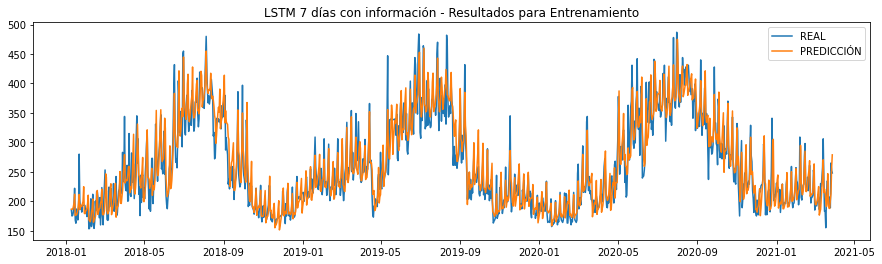

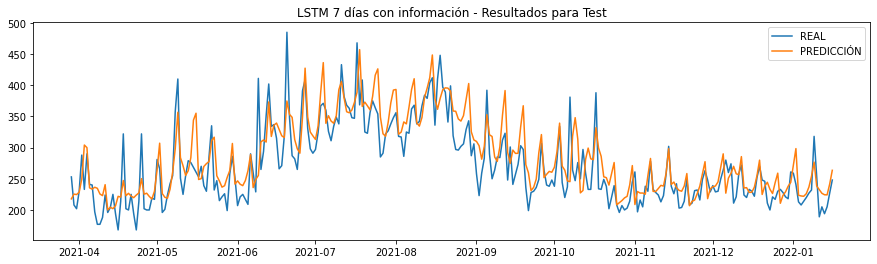

In [15]:
supporter.grafica_resultado(predictor_7d_info,"LSTM 7 días con información", df_7d_info,
                            train_size,test_size,show_scaled=False)

In [16]:
supporter.regression_results(y_test_7d_info, predictor_7d_info.predict(X_test_7d_info))

r2:  0.69
MAE:  0.08
MSE:  0.01
RMSE:  0.1
MAPE (%):  21.32


# 14 días sin información diaria

In [17]:
df_14d_no_info = pd.read_csv(r'./consumo_diario_03_14d_no_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [18]:
X_train_14d_no_info, X_test_14d_no_info, y_train_14d_no_info, y_test_14d_no_info = supporter.split_train_test_deep(df_14d_no_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_14d_no_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_LSTM, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_14d_no_info, y_train_14d_no_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'LSTM_14d_no_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_14d_no_info_RMSE, _14d_no_info_MAE, _14d_no_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                                X_train_14d_no_info,
                                                                                                y_train_14d_no_info, cv,
                                                                                                '14 días sin información diaria')
joblib.dump(_14d_no_info_RMSE, 'LSTM_14d_no_info_normalizado_RMSE_training.pkl')
joblib.dump(_14d_no_info_MAE, 'LSTM_14d_no_info_normalizado_MAE_training.pkl')
joblib.dump(_14d_no_info_MAPE, 'LSTM_14d_no_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('LSTM_14d_no_info_normalizado_best_model.h5')

In [19]:
best_conf = joblib.load('LSTM_14d_no_info_normalizado_best_conf.pkl')
best_conf

{'_units': 50, 'batch_size': 10, 'epochs': 50}

In [20]:
_14d_no_info_RMSE = joblib.load('LSTM_14d_no_info_normalizado_RMSE_training.pkl')
_14d_no_info_MAE = joblib.load('LSTM_14d_no_info_normalizado_MAE_training.pkl')
_14d_no_info_MAPE = joblib.load('LSTM_14d_no_info_normalizado_MAPE_training.pkl')

In [21]:
predictor_14d_no_info = load_model('LSTM_14d_no_info_normalizado_best_model.h5')

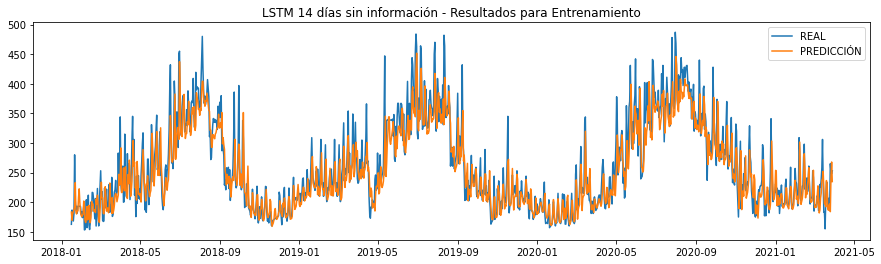

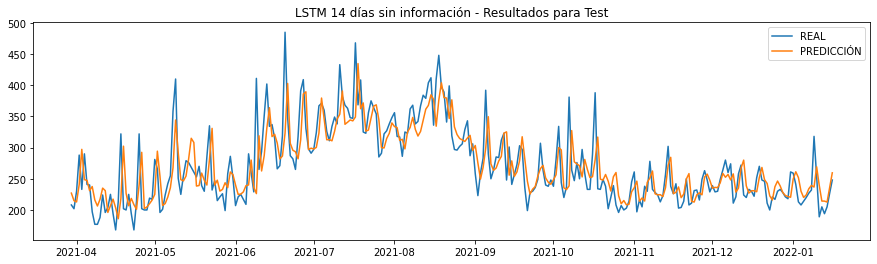

In [22]:
supporter.grafica_resultado(predictor_14d_no_info,"LSTM 14 días sin información", df_14d_no_info,
                            train_size,test_size,show_scaled=False)

In [23]:
supporter.regression_results(y_test_14d_no_info, predictor_14d_no_info.predict(X_test_14d_no_info))

r2:  0.6
MAE:  0.08
MSE:  0.01
RMSE:  0.12
MAPE (%):  23.51


# 14 días con información diaria

In [24]:
df_14d_info = pd.read_csv(r'./consumo_diario_03_14d_info.csv',parse_dates=["Fecha"], index_col=["Fecha"])

In [25]:
X_train_14d_info, X_test_14d_info, y_train_14d_info, y_test_14d_info = supporter.split_train_test_deep(df_14d_info,
                                                train_size_=train_size,test_size_=test_size,
                                                target="Consumo(t)", _scale=True,verbose=False)

n_predictors = X_train_14d_info.shape[1]
n_features = 1

In [ ]:
grid = GridSearchCV(estimator=model_LSTM, param_grid=parameter_space, n_jobs=-1, cv=cv)

grid_result = grid.fit(X_train_14d_info, y_train_14d_info)

best_conf = grid_result.best_params_
joblib.dump(best_conf, 'LSTM_14d_info_normalizado_best_conf.pkl')

best_estimator = grid_result.best_estimator_
_14d_info_RMSE, _14d_info_MAE, _14d_info_MAPE = supporter.crear_tabla_errores_cv_train(best_estimator,
                                                                                       X_train_14d_info,
                                                                                       y_train_14d_info, cv,
                                                                                       '14 días con información diaria')
joblib.dump(_14d_info_RMSE, 'LSTM_14d_info_normalizado_RMSE_training.pkl')
joblib.dump(_14d_info_MAE, 'LSTM_14d_info_normalizado_MAE_training.pkl')
joblib.dump(_14d_info_MAPE, 'LSTM_14d_info_normalizado_MAPE_training.pkl')

predictor = best_estimator.model
predictor.save('LSTM_14d_info_normalizado_best_model.h5')

In [26]:
best_conf = joblib.load('LSTM_14d_info_normalizado_best_conf.pkl')
best_conf

{'_units': 100, 'batch_size': 10, 'epochs': 50}

In [27]:
_14d_info_RMSE = joblib.load('LSTM_14d_info_normalizado_RMSE_training.pkl')
_14d_info_MAE = joblib.load('LSTM_14d_info_normalizado_MAE_training.pkl')
_14d_info_MAPE = joblib.load('LSTM_14d_info_normalizado_MAPE_training.pkl')

In [28]:
predictor_14d_info = load_model('LSTM_14d_info_normalizado_best_model.h5')

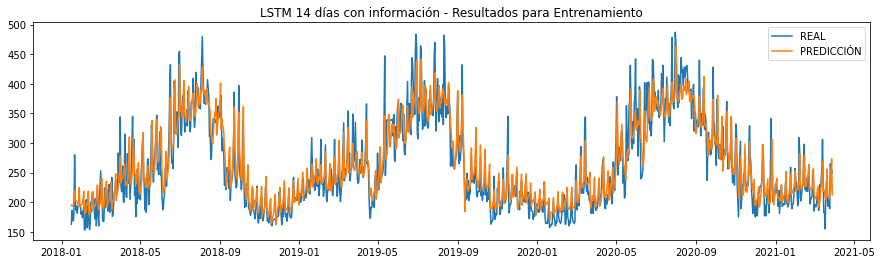

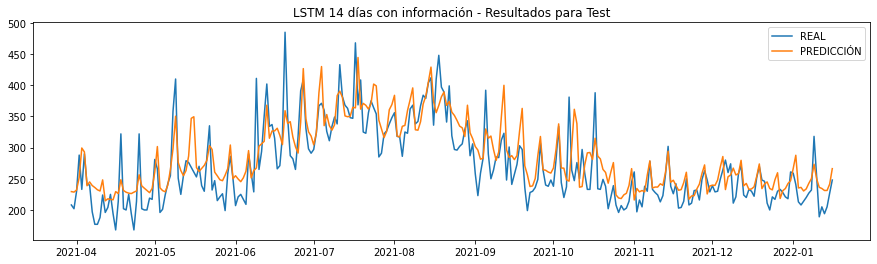

In [29]:
supporter.grafica_resultado(predictor_14d_info,"LSTM 14 días con información", df_14d_info,
                            train_size,test_size,show_scaled=False)

In [30]:
supporter.regression_results(y_test_14d_info, predictor_14d_info.predict(X_test_14d_info))

r2:  0.7
MAE:  0.07
MSE:  0.01
RMSE:  0.1
MAPE (%):  20.55


# Juntamos todos los errores de entrenamiento

#### RMSE

In [31]:
errores_training_rmse = pd.concat([_7d_no_info_RMSE, _7d_info_RMSE, _14d_no_info_RMSE, _14d_info_RMSE], axis=1)
errores_training_rmse

,7 días sin información diaria,7 días con información diaria,14 días sin información diaria,14 días con información diaria
Pliegues,,,,
Pliegue 1,0.165157,0.131765,0.161224,0.155885
Pliegue 2,0.101339,0.138878,0.097384,0.118983
Pliegue 3,0.066952,0.083864,0.071702,0.088540
Pliegue 4,0.122794,0.116039,0.122920,0.120175
Pliegue 5,0.114628,0.103736,0.111553,0.104582
Pliegue 6,0.063403,0.055339,0.061227,0.060468
Pliegue 7,0.085142,0.084055,0.087657,0.079421
Pliegue 8,0.118437,0.107985,0.116798,0.111440
Pliegue 9,0.108505,0.093563,0.099787,0.094490


In [32]:
errores_training_rmse.to_csv("./LSTM_rmse_training.csv")

[Text(0.5, 0, 'Dataset utilizado'), Text(0, 0.5, 'RMSE')]

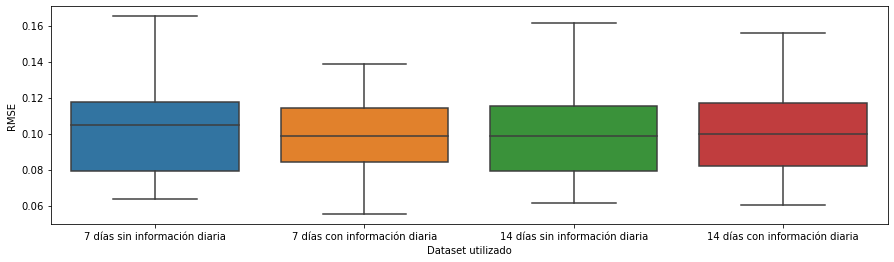

In [33]:
sns.boxplot(data=errores_training_rmse).set(xlabel='Dataset utilizado', ylabel='RMSE')

#### MAE

In [34]:
errores_training_mae = pd.concat([_7d_no_info_MAE, _7d_info_MAE, _14d_no_info_MAE, _14d_info_MAE], axis=1)
errores_training_mae

,7 días sin información diaria,7 días con información diaria,14 días sin información diaria,14 días con información diaria
Pliegues,,,,
Pliegue 1,0.108806,0.084322,0.102495,0.121204
Pliegue 2,0.057720,0.099569,0.052003,0.094020
Pliegue 3,0.032614,0.050929,0.042417,0.045219
Pliegue 4,0.074161,0.052042,0.078156,0.078261
Pliegue 5,0.064357,0.060125,0.062262,0.062123
Pliegue 6,0.036279,0.037174,0.032486,0.040177
Pliegue 7,0.044437,0.058195,0.050468,0.052649
Pliegue 8,0.066859,0.062931,0.067978,0.067893
Pliegue 9,0.075006,0.056671,0.062813,0.056587


In [35]:
errores_training_mae.to_csv("./LSTM_mae_training.csv")

[Text(0.5, 0, 'Dataset utilizado'), Text(0, 0.5, 'MAE')]

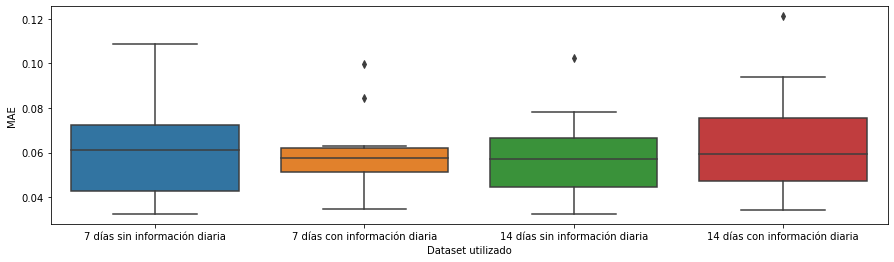

In [36]:
sns.boxplot(data=errores_training_mae).set(xlabel='Dataset utilizado', ylabel='MAE')

#### MAPE

In [37]:
errores_training_mape = pd.concat([_7d_no_info_MAPE, _7d_info_MAPE, _14d_no_info_MAPE, _14d_info_MAPE], axis=1)
errores_training_mape

,7 días sin información diaria,7 días con información diaria,14 días sin información diaria,14 días con información diaria
Pliegues,,,,
Pliegue 1,30.108717,27.955524,29.966234,30.834114
Pliegue 2,50.682103,93.905188,46.494937,85.318175
Pliegue 3,25.800512,32.684191,29.768099,29.191637
Pliegue 4,28.514084,24.127418,28.193401,29.704532
Pliegue 5,21.039180,22.139533,21.285462,22.306861
Pliegue 6,53.893854,48.363130,56.286101,59.010047
Pliegue 7,41.362832,57.695402,37.068003,52.190528
Pliegue 8,15.819838,13.777560,15.065769,14.904303
Pliegue 9,32.351294,24.250833,29.364461,25.372351


In [38]:
errores_training_mape.to_csv("./LSTM_mape_training.csv")

[Text(0.5, 0, 'Dataset utilizado'), Text(0, 0.5, 'MAPE')]

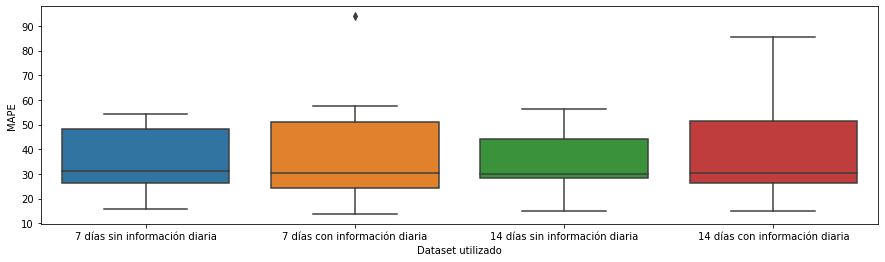

In [39]:
sns.boxplot(data=errores_training_mape).set(xlabel='Dataset utilizado', ylabel='MAPE')